# CNN WITH GPU

<b>
    
    Steve Marquez
    
    Sandra Zelen
    
    Leah Kim
    
</b>

In [1]:
import cv2
import os
import glob
import torch
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import time


warnings.filterwarnings('ignore')
torch.set_default_tensor_type("torch.FloatTensor")

In [2]:
# Augmented dataset

def rand_crop(img):
    height, width = int(img.shape[0]*0.4), int(img.shape[1]*0.4)
    x = random.randint(0, img.shape[1] - int(width))
    y = random.randint(0, img.shape[0] - int(height))
    cropped = img[y:y+height, x:x+width]
    resized = cv2.resize(cropped, (img.shape[1], img.shape[0]))
    return resized

def h_flip(img):
    flip = cv2.flip(img,1)
    return flip

def rand_scaling(img):
    scale_img = img
    scale = random.uniform(0.6, 1.0)
    for pixel in scale_img:
        pixel[0] = pixel[0] * scale
        pixel[1] = pixel[1] * scale
        pixel[2] = pixel[2] * scale
    return scale_img

def create_augmented_data(d):
    ad = list()

    for img in d:

        # random cropping
        ad.append(rand_crop(img))
        ad.append(rand_crop(img))

        # horizontal flips
        ad.append(h_flip(img))

        # random scaling
        ad.append(rand_scaling(img))
        ad.append(rand_scaling(img))

        # cropping + flip
        ad.append(rand_crop(h_flip(img)))

        # cropping + scaling
        ad.append(rand_crop(rand_scaling(img)))

        # flip + scaling
        ad.append(h_flip(rand_scaling(img)))

        # all three augments applied
        ad.append(h_flip(rand_scaling(rand_crop(img))))

    return ad


In [3]:
def norm_l_channel(tens):
    norm_tens = torch.div(tens, 255.0)
    return norm_tens

def rescale(tens):
    resc_tens = torch.mul(tens, 255.0)
    return resc_tens

In [4]:
class Colorize_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.downsize = torch.nn.Sequential(
                            torch.nn.Conv2d(1, 64, 3, stride=2, padding=1),
                            torch.nn.BatchNorm2d(64),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(64, 128, 3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(128),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(128, 128, 3, stride=2, padding=1),
                            torch.nn.BatchNorm2d(128),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(128, 256, 3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(256),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(256, 256, 3, stride=2, padding=1),
                            torch.nn.BatchNorm2d(256),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(256, 512, 3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ReLU()
                        )

        self.downsize_remaining = torch.nn.Sequential(
                                    torch.nn.Conv2d(512, 512, 3, stride=1, padding=1),
                                    torch.nn.BatchNorm2d(512),
                                    torch.nn.ReLU(),
                                    torch.nn.Conv2d(512, 256, 3, stride=1, padding=1),
                                    torch.nn.BatchNorm2d(256),
                                    torch.nn.ReLU()
                                )

        self.upsample = torch.nn.Sequential(
                            torch.nn.Conv2d(256, 128, 3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(128),
                            torch.nn.ReLU(),
                            torch.nn.Upsample(scale_factor=(2,2), mode='nearest'),
                            torch.nn.Conv2d(128, 64, 3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(64),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(64, 64, 3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(64),
                            torch.nn.ReLU(),
                            torch.nn.Upsample(scale_factor=(2,2), mode='nearest'),
                            torch.nn.Conv2d(64, 32, 3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(32),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(32, 2, 3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(2),
                            torch.nn.Sigmoid(),
                            torch.nn.Upsample(scale_factor=(2,2), mode='nearest')
                    )

        self.g_model = torch.nn.Sequential(
                            torch.nn.Conv2d(512, 512, 3, stride=2, padding=1),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(512, 512, 3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(512, 512, 3, stride=2, padding=1),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(512, 512, 3, stride=1, padding=1),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ReLU()
                        )


        self.g_net = torch.nn.Sequential(
                          torch.nn.Linear(512 * 4 * 4, 1024),
                          torch.nn.ReLU(),
                          torch.nn.Linear(1024, 512),
                          torch.nn.ReLU(),
                          torch.nn.Linear(512, 256),
                          torch.nn.ReLU()
                        )

        self.fn_net = torch.nn.Sequential(
                            torch.nn.Linear(256 * 16 * 16 * 2, 256),
                            torch.nn.ReLU()
                        )

    def forward(self, img):
        c_img = self.downsize(img)
        mid_lvl = self.downsize_remaining(c_img)
        f_c_img = self.fusion_layer(c_img, mid_lvl)
        final = self.upsample(f_c_img)
        return final

    def global_features(self, features):
        features_network = self.g_model(features)
        features_network = torch.flatten(features_network, 1)
        g_f = self.g_net(features_network)
        return g_f

    def fusion_layer(self, cimg, mid_lvl_ft):
        gf = self.global_features(cimg)
        gf = gf.unsqueeze(2).unsqueeze(3)
        gf = gf.expand(-1,-1, 16, 16)
        merged_features = torch.cat((mid_lvl_ft, gf), dim=1)
        merged_features = torch.flatten(merged_features, 1)
        colorized_img = self.fn_net(merged_features)
        colorized_img = colorized_img.unsqueeze(2).unsqueeze(3)
        colorized_img = colorized_img.expand(-1, -1, 16, 16)
        return colorized_img

In [5]:
# Helper Functions
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label


def create_sets(data):
    shuffled = data.copy()
    np.random.shuffle(shuffled)
    split = int(0.9* len(shuffled))
    test_imgs = shuffled[split:]
    train_imgs = shuffled[:split]

    # add augmented data
    aug_dataset = create_augmented_data(train_imgs)
    train_imgs.extend(aug_dataset)

    # convert both images into L*a*b* channels
    alt_train_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in train_imgs]
    alt_test_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in test_imgs]
    alt_train_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in alt_train_imgs]
    alt_test_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in alt_test_imgs]

    # put them inside tensors and adjust dimentions
    alt_train_imgs = torch.tensor(alt_train_imgs)
    alt_test_imgs = torch.tensor(alt_test_imgs)
    alt_train_imgs = alt_train_imgs.permute(0,3,1,2)
    alt_test_imgs = alt_test_imgs.permute(0,3,1,2)

    alt_train_imgs = MyDataset(alt_train_imgs[:,0,:,:].float(), alt_train_imgs[:,1:,:,:].float())
    alt_test_imgs = MyDataset(alt_test_imgs[:,0,:,:].float(), alt_test_imgs[:,1:,:,:].float())
    return alt_train_imgs, alt_test_imgs


# requires 4D tensors --> returns a list of merged images even if we are merging only one img
def merge_layers(l_layer, a_b_layers):

    new_imgs = list()

    l_star = l_layer.detach().cpu().numpy().astype('uint8')
    a_b_star = a_b_layers.detach().cpu().numpy().astype('uint8')

    for l, a_b in zip(l_star, a_b_star):
      a = a_b[0, :, :]
      b = a_b[1, :, :]
      merged = cv2.merge((l, a, b))
      merged = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
      new_imgs.append(merged)

    return new_imgs


# Actual Algorithm
def train_model(model, num_epochs, train_set, device):
    MSE = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    error = list()
    new_images = list()
    for epoch in range(num_epochs):
      for inputs, labels in train_set:
          optimizer.zero_grad()
          adjusted_imputs = (norm_l_channel(inputs)).unsqueeze(0).permute(1,0,2,3).to(device)
          outputs = model(adjusted_imputs)
          loss = MSE(rescale(outputs), labels.to(device))
          loss.backward()
          optimizer.step()
      error.append(torch.tensor(loss).cpu())
      print(f"Training Epoch {epoch+1}/{num_epochs}, Loss: {(loss.item()):<12.2f}")
      # merge layers produces a set of images. for visualization purposes,
      # we only want to visualize the last image of our train_set only
      images = merge_layers(inputs[-1].unsqueeze(0), (rescale(outputs[-1])).unsqueeze(0))
      new_images.append(images)
    print('Training Complete!\n')
    print(f'{"-"*50}')
    new_images = [inner for outer in new_images for inner in outer]
    return error, new_images

def test_model(model, test_set, device):
    error = list()
    new_images = list()
    original_images = list()
    MSE = torch.nn.MSELoss()
    with torch.no_grad():
        for inputs, labels in test_set:
            adjusted_imputs = (norm_l_channel(inputs)).unsqueeze(0).permute(1,0,2,3).to(device)
            output = model(adjusted_imputs)
            loss = MSE(rescale(output), labels.to(device))
            error.append(torch.tensor(loss).cpu())
            new_images.append(merge_layers(inputs, rescale(output)))
            original_images.append(merge_layers(inputs, labels))
    print(f'Overall Testing Error: {(sum(error) / len(test_set)):.2f}')
    print('Testing Complete! \n')
    print(f'{"-"*50}')
    new_images = [inner for outer in new_images for inner in outer]
    original_images = [inner for outer in original_images for inner in outer]
    return error, new_images, original_images


<u><b> TESTING AND TRAINING </b></u>

In [6]:
# GPU programming
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [7]:
from google.colab import drive

drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/Project2/face_images'
files = os.listdir(folder_path)
data = []
for f1 in files:
    img = cv2.imread(os.path.join(folder_path, f1))
    img_resized = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
    data.append(img_resized)

Mounted at /content/drive


In [8]:
train_data, test_data = create_sets(data)
print(f"Training and Testing data sets created!")
print('---------------------------------------------------------\n')
print(f'{"Number of images in dataset: ":<50} {len(data):,}\n')
print(f'{"Number of training images (with augmentation): ":<50} {len(train_data):,}\n')
print(f'{"Number of testing images: ":<50} {len(test_data):,}\n')

Training and Testing data sets created!
---------------------------------------------------------

Number of images in dataset:                       750

Number of training images (with augmentation):     6,750

Number of testing images:                          75



In [10]:
epochs = 50
mini_batch_size = 8

train_set = DataLoader(train_data, batch_size=mini_batch_size, shuffle=True, num_workers=4)
test_set = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)

start_timer = time.time()
#------------------------------------

c_model = Colorize_Model().to(device)

c_model.train()
# we retrive the original images during training for visualization purposes only
tr_error_results, new_training_images = train_model(c_model, epochs, train_set, device)

c_model.eval()
tst_error_results, new_color_images, original_images = test_model(c_model, test_set, device)


#------------------------------------
end_timer = time.time()

print(f"Training and testing this CNN took: {((end_timer-start_timer)/60.0):.2f} mins")

Training Epoch 1/50, Loss: 194.08      
Training Epoch 2/50, Loss: 109.93      
Training Epoch 3/50, Loss: 74.95       
Training Epoch 4/50, Loss: 90.76       
Training Epoch 5/50, Loss: 88.48       
Training Epoch 6/50, Loss: 27.94       
Training Epoch 7/50, Loss: 44.96       
Training Epoch 8/50, Loss: 35.40       
Training Epoch 9/50, Loss: 46.53       
Training Epoch 10/50, Loss: 35.28       
Training Epoch 11/50, Loss: 34.27       
Training Epoch 12/50, Loss: 34.43       
Training Epoch 13/50, Loss: 30.16       
Training Epoch 14/50, Loss: 26.81       
Training Epoch 15/50, Loss: 20.77       
Training Epoch 16/50, Loss: 36.04       
Training Epoch 17/50, Loss: 23.27       
Training Epoch 18/50, Loss: 32.74       
Training Epoch 19/50, Loss: 31.33       
Training Epoch 20/50, Loss: 26.09       
Training Epoch 21/50, Loss: 28.62       
Training Epoch 22/50, Loss: 34.11       
Training Epoch 23/50, Loss: 23.93       
Training Epoch 24/50, Loss: 48.76       
Training Epoch 25/50, Los

<u><b> ANALYSIS </b></u>

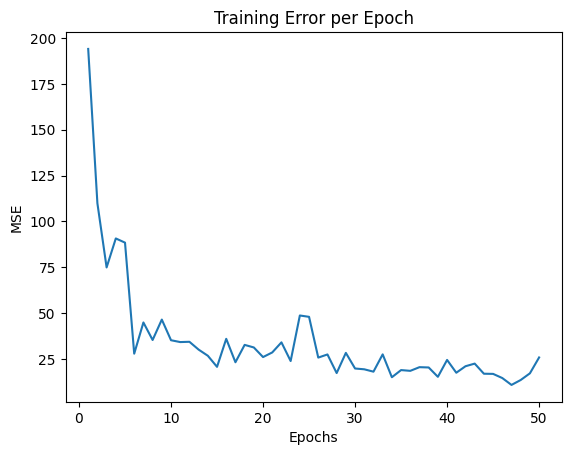

In [11]:
plt.title("Training Error per Epoch")
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.plot(range(1,epochs+1), tr_error_results)

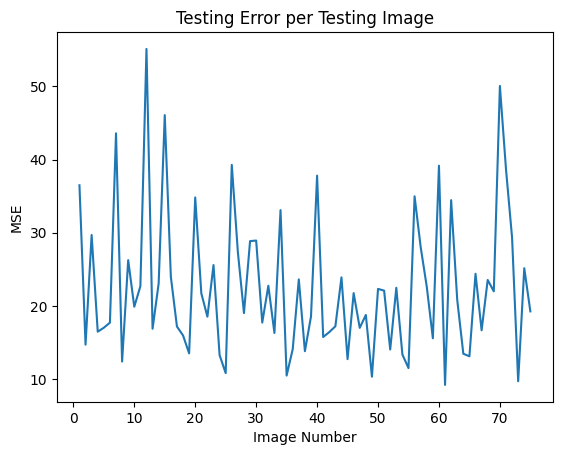

In [12]:
plt.title("Testing Error per Testing Image")
plt.ylabel("MSE")
plt.xlabel("Image Number")
plt.plot(range(1, len(test_data)+1), tst_error_results)

In [ ]:
# recolored_img_folder = '/content/drive/My Drive/Project2/recolored_img_folder'
# os.makedirs(recolored_img_folder, exist_ok=True)
# for i in range (len(results[4])):
#       cv2.imwrite(os.path.join(recolored_img_folder, f"new_img{i}.jpg"), results[4][1])

# test_recolored_img_folder = '/content/drive/My Drive/Project2/test_recolored_img_folder'
# os.makedirs(test_recolored_img_folder, exist_ok=True)
# for j in range (len(results[5])):
#       cv2.imwrite(os.path.join(test_recolored_img_folder, f"new_img{i}.jpg"), results[5][1])

In [13]:
def visualize_test_changes(before, after, n):
    fig = plt.figure(figsize=(7, 30))
    for i in range(n):
        ax = plt.subplot(n, 3, 3*i + 1)
        plt.imshow(before[i])
        ax.set_title("Original")
        ax.axis("off")
        ax = plt.subplot(n, 3, 3*i + 2)
        plt.imshow((cv2.cvtColor(before[i], cv2.COLOR_RGB2GRAY)), cmap='gray')
        ax.set_title("L Channel")
        ax.axis("off")
        ax = plt.subplot(n, 3, 3*i + 3)
        plt.imshow(after[i])
        ax.set_title("Recolored")
        ax.axis("off")
    plt.show()

def visualize_train_changes(imgs, n):
    fig = plt.figure(figsize=(5, 80))
    imgs = torch.tensor(imgs)
    for i in range(n):
        ax = plt.subplot(n, 1, i+1)
        plt.imshow(imgs[i])
        ax.set_title(f'Epoch {i+1}')
        ax.axis("off")
    plt.show()

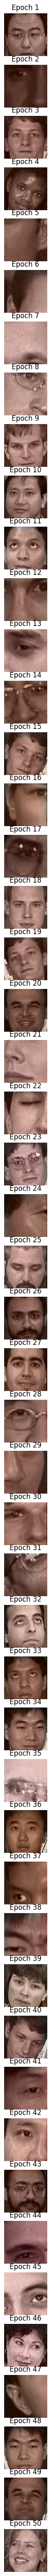

In [16]:
visualize_train_changes(new_training_images, epochs)

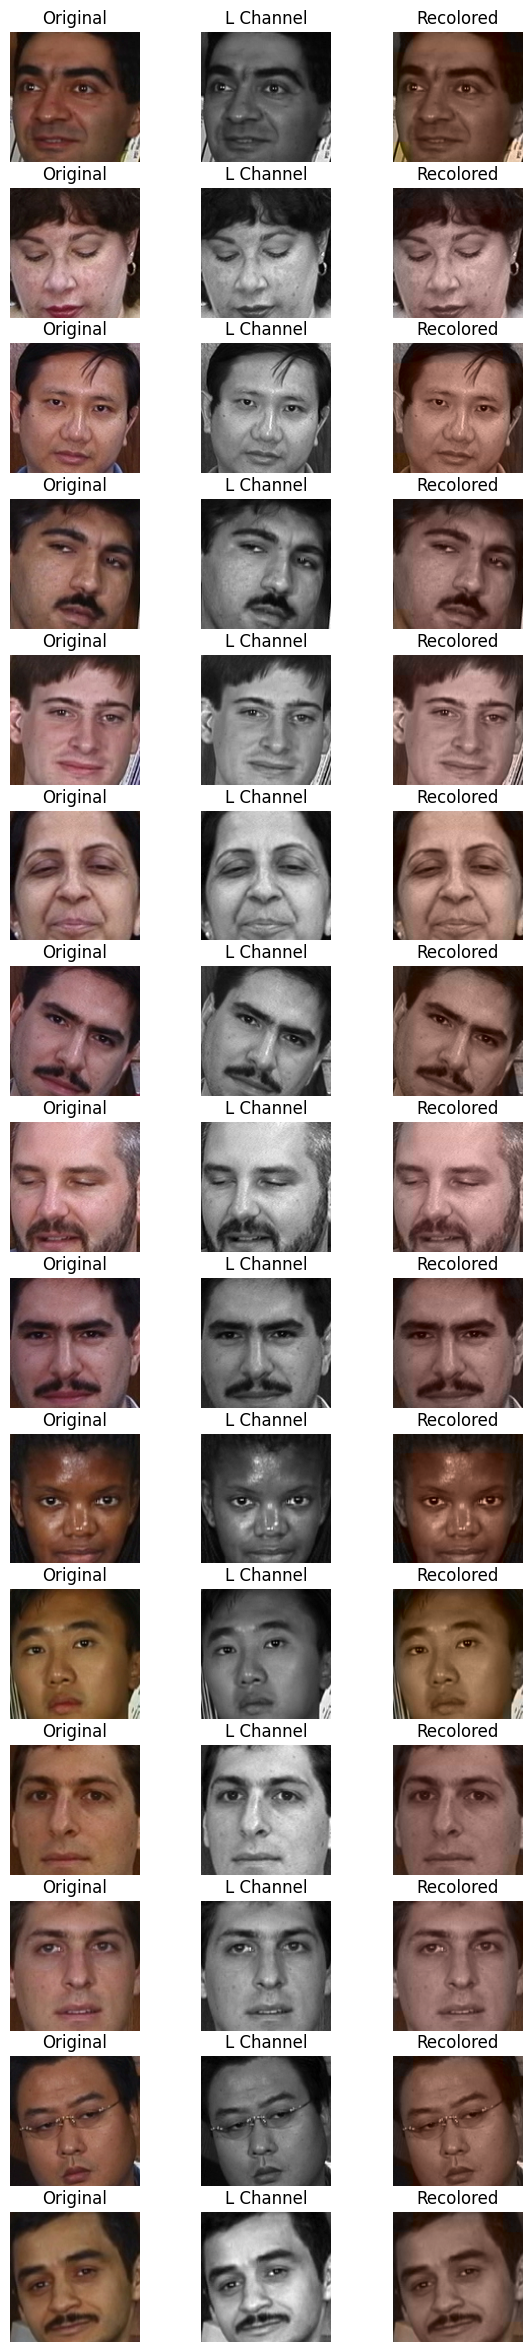

In [17]:
visualize_test_changes(original_images, new_color_images, 15)

<b><u> Transfer Learning: </u></b>

In [14]:
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import cv2
from google.colab import drive
import os
import glob
import random
import warnings
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [19]:
#saving the model:
torch.save(c_model.state_dict(), '/content/drive/My Drive/Project2/Colorize_Model_Weights.pth')

# Load the pre-trained model weights - - - - - - - - - - - - - - - - - - - - - - - -
#instantiate the Colorize_Model class
colorizeModel = Colorize_Model()
# load its pre-trained weights from a file
colorizeModel.load_state_dict(torch.load('/content/drive/My Drive/Project2/Colorize_Model_Weights.pth'))
#set it to evaluation mode --> will not be affected by dropout or batch normalization layers during inference

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
colorizeModel.to(device)


#set the path to the NCD dataset and uses ImageFolder to load images and labels from the directory
# ncdPath = '/content/drive/My Drive/Project2/ColorfulOriginal/'

# drive.mount('/content/drive')
# files = os.listdir(ncdPath)
# data = []
# for subdir, dirs, files in os.walk(ncdPath):
#         for f1 in files:
#             img = cv2.imread(os.path.join(subdir, f1))
#             img_resized = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
#             data.append(img_resized)

# Split the dataset into train and validation sets (90%-10% split) based on total # of images
shuffled = data.copy()
np.random.shuffle(shuffled)
split = int(0.9* len(shuffled))
test_imgs = shuffled[split:]
train_imgs = shuffled[:split]

# convert both images into L*a*b* channels
alt_train_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in train_imgs]
alt_test_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in test_imgs]
alt_train_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in alt_train_imgs]
alt_test_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in alt_test_imgs]

# put them inside tensors and adjust dimentions
alt_train_imgs = torch.tensor(alt_train_imgs)
alt_test_imgs = torch.tensor(alt_test_imgs)
alt_train_imgs = alt_train_imgs.permute(0,3,1,2)
alt_test_imgs = alt_test_imgs.permute(0,3,1,2)

alt_train_imgs = MyDataset(alt_train_imgs[:,0,:,:].float(), alt_train_imgs[:,1:,:,:].float())
alt_test_imgs = MyDataset(alt_test_imgs[:,0,:,:].float(), alt_test_imgs[:,1:,:,:].float())

# Create DataLoader instances for both training and validation datasets
train_loader = DataLoader(alt_train_imgs, batch_size=32, shuffle=True)
val_loader = DataLoader(alt_test_imgs, batch_size=1, shuffle=False)

print(f"Training and Testing data sets created!")
print('---------------------------------------------------------\n')
print(f'{"Number of images in dataset: ":<50} {len(data):,}\n')
print(f'{"Number of training images: ":<50} {len(alt_train_imgs):,}\n')
print(f'{"Number of testing images: ":<50} {len(alt_test_imgs):,}\n')

epochs = 10
# Training loop
colorizeModel.train()
tr_error_results, new_training_images = train_model(colorizeModel, epochs, train_loader, device)

# Save the fine-tuned model
torch.save(colorizeModel.state_dict(), '/content/drive/My Drive/Project2/Colorize_Model_Fine_Tuned.pth')

# Testing Loop
colorizeModel.eval()
tst_error_results, new_color_images, original_images = test_model(colorizeModel, val_loader, device)


Training and Testing data sets created!
---------------------------------------------------------

Number of images in dataset:                       721

Number of training images:                         648

Number of testing images:                          73

Training Epoch 1/10, Loss: 396.46      
Training Epoch 2/10, Loss: 440.38      
Training Epoch 3/10, Loss: 449.18      
Training Epoch 4/10, Loss: 293.62      
Training Epoch 5/10, Loss: 321.60      
Training Epoch 6/10, Loss: 335.44      
Training Epoch 7/10, Loss: 240.41      
Training Epoch 8/10, Loss: 334.67      
Training Epoch 9/10, Loss: 355.68      
Training Epoch 10/10, Loss: 230.40      
Training Complete!

--------------------------------------------------
Overall Testing Error: 323.41
Testing Complete! 

--------------------------------------------------


ANALYSIS:

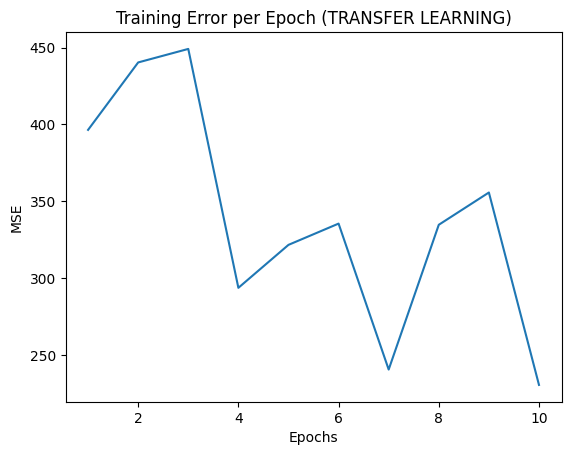

In [20]:
plt.title("Training Error per Epoch (TRANSFER LEARNING)")
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.plot(range(1,epochs+1), tr_error_results)

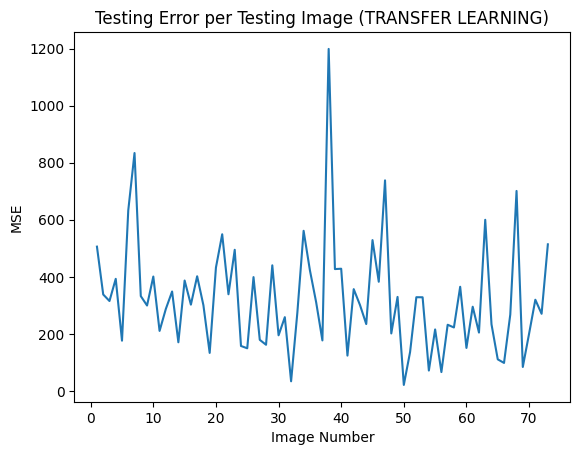

In [21]:
plt.title("Testing Error per Testing Image (TRANSFER LEARNING)")
plt.ylabel("MSE")
plt.xlabel("Image Number")
plt.plot(range(1, len(alt_test_imgs)+1), tst_error_results)

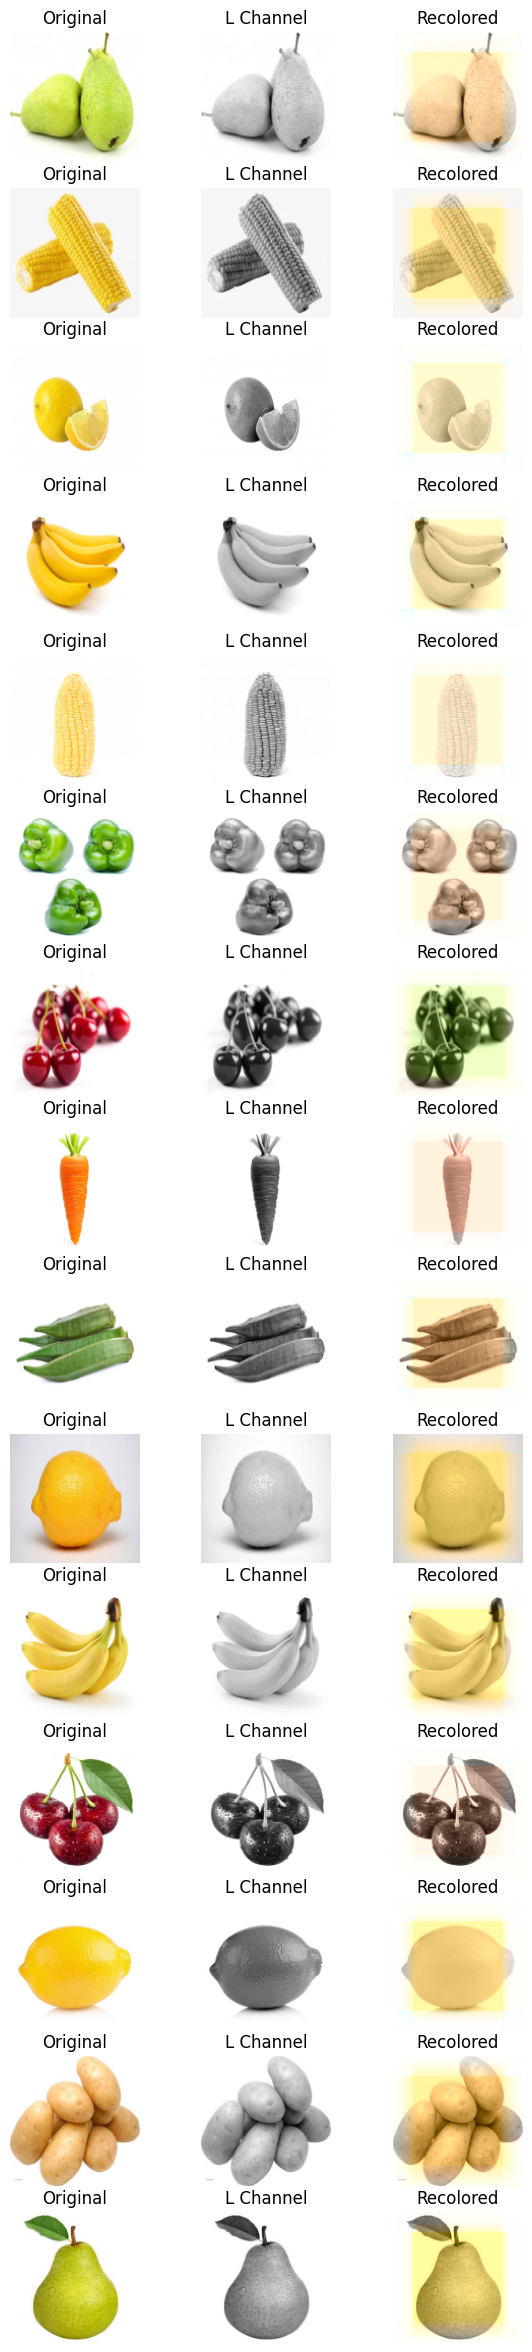

In [22]:
visualize_test_changes(original_images, new_color_images, 15)